In [1]:
import cv2
import numpy as np
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import math

# Q1

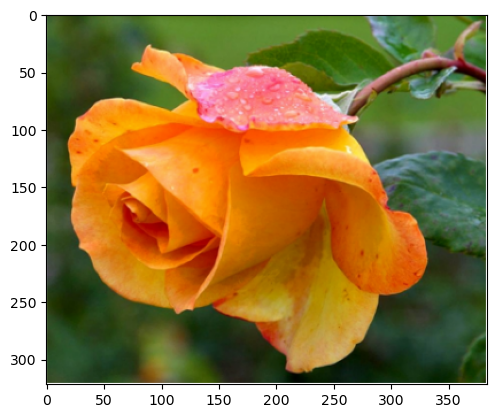

(322, 384, 3)

In [5]:
loc="input1.PNG"
img0=cv2.imread(loc)
size=img0.shape
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
plt.imshow(img0)
plt.show()
IMG_W, IMG_H,IMG_D=size
IMG_W, IMG_H,IMG_D

## Apply histogram equalisation on each channel

(322, 384, 3)


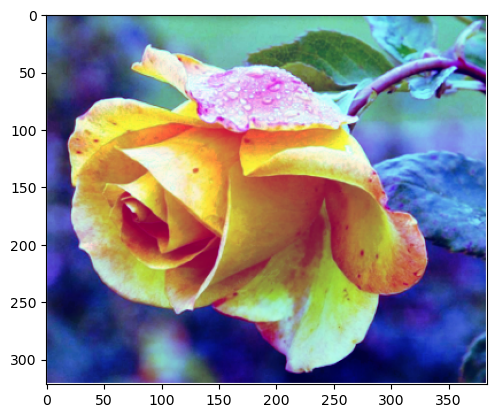

In [10]:
def make_histogram(img,i):
    vals = img[:,:,i].flatten()
    hist = np.zeros(256, dtype=int)
    for index in range(vals.size):
        hist[vals[index]] += 1
    return hist

def make_cumsum(histogram):
    cumsum = np.zeros(256, dtype=int)
    cumsum[0] = histogram[0]
    for i in range(1, histogram.size):
        cumsum[i] = cumsum[i-1] + histogram[i]
    return cumsum

def make_mapping(histogram, cumsum):
    mapping = np.zeros(256, dtype=int)
    luma_levels = 256
    for i in range(histogram.size):
        mapping[i] = max(0, round((luma_levels*cumsum[i])/(IMG_H*IMG_W))-1)
    return mapping

def apply_mapping(img, map1,map2,map3):
    new_image = img.copy()
    print(new_image.shape)
    new_image[:,:,0] = list(map(lambda a : map1[a], img[:,:,0]))
    new_image[:,:,1] = list(map(lambda a : map2[a], img[:,:,1]))
    new_image[:,:,2] = list(map(lambda a : map3[a], img[:,:,2]))
    return new_image

img = np.array(img0)
hist_r = make_histogram(img,0)
hist_g = make_histogram(img,1)
hist_b = make_histogram(img,2)
cum1 = make_cumsum(hist_r)
cum2 = make_cumsum(hist_g)
cum3 = make_cumsum(hist_b)
map1 = make_mapping(hist_r,cum1)
map2 = make_mapping(hist_g,cum2)
map3 = make_mapping(hist_b,cum3)
new_image = apply_mapping(img0, map1,map2,map3)

output = Image.fromarray(new_image)
plt.imshow(output)
plt.show()

## Convert to HSI space then equalise and then convert back to RGB

<ipython-input-8-66a829da75a1>:18: RuntimeWarning: invalid value encountered in double_scalars
  hue[i][j] = 0.5 * ((red[i][j] - green[i][j]) + (red[i][j] - blue[i][j])) /\
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


HSI space image


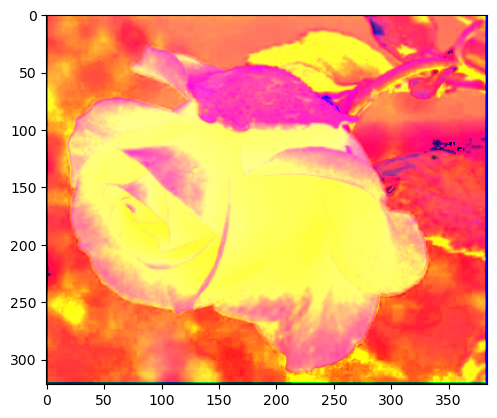

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


HSI space histogram equalised image


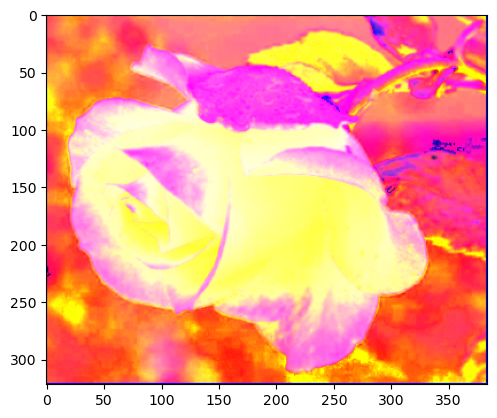

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


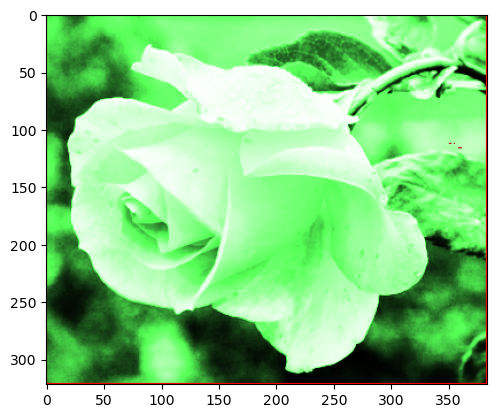

(322, 384, 3)

In [8]:
bgr = np.float32(img0)/255
blue = bgr[:,:,0]
green = bgr[:,:,1]
red = bgr[:,:,2]

def calc_intensity(red, blue, green):
    return np.divide(blue + green + red, 3)

def calc_saturation(red, blue, green):
    minimum = np.minimum(np.minimum(red, green), blue)
    saturation = 1 - (3 / (red + green + blue + 0.0001) * minimum)
    return saturation

def calc_hue(red, blue, green):
    hue = np.copy(red)
    for i in range(0, blue.shape[0]):
        for j in range(0, blue.shape[1]):
            hue[i][j] = 0.5 * ((red[i][j] - green[i][j]) + (red[i][j] - blue[i][j])) /\
                        math.sqrt((red[i][j] - green[i][j])**2 +((red[i][j] - blue[i][j]) * (green[i][j] - blue[i][j])))
            hue[i][j] = math.acos(hue[i][j])

            if blue[i][j] <= green[i][j]:
                hue[i][j] = hue[i][j]
            else:
                hue[i][j] = ((360 * math.pi) / 180.0) - hue[i][j]
    return hue

hsi = cv2.merge((calc_hue(red, blue, green), calc_saturation(red, blue, green), calc_intensity(red, blue, green)))
print("HSI space image")
plt.imshow(hsi)
plt.show()
IMG_W, IMG_H,IMG_D=hsi.shape
hsi=hsi*1000
hsi=np.rint(hsi)
hsi=hsi.astype(np.int64)
img = np.array(hsi)
vals = img[:,:,2].flatten()
hist_i = np.zeros(1001, dtype=int)
for index in range(vals.size):
    hist_i[int(vals[index])] += 1
cumi = np.zeros(1001, dtype=int)
cumi[0] = hist_i[0]
for i in range(1, hist_i.size):
    cumi[i] = cumi[i-1] + hist_i[i]
mapi = np.zeros(1001, dtype=int)
luma_levels = 1001
for i in range(hist_i.size):
    mapi[i] = max(0, round((luma_levels*cumi[i])/(IMG_H*IMG_W))-1)
new_image = img.copy()
new_image[:,:,2] = list(map(lambda a : mapi[a], img[:,:,2]))
new_image=new_image/1000
print("HSI space histogram equalised image")
plt.imshow(new_image)
plt.show()
def  HSI2RGB (hsi_img) : 
    # The number of rows and columns to save the original image 
    row = np.shape(hsi_img)[ 0 ]
    col = np.shape(hsi_img)[ 1 ]
     #Copy the original image
    rgb_img = hsi_img.copy()
    #Channel splitting the image
    H,S,I = cv2.split(hsi_img)
    # Normalize the channel to [0,1] 
    [H,S,I] = [i/255.0  for i in ([H,S,I])]
    R,G,B = H,S,I
    for i in range(row):
        h = H[i]* 2 *np.pi
         #H is greater than or equal to 0 and less than 120 degrees when 
        a1 = h >= 0 
        a2 = h < 2 *np.pi/3 
        a = a1 & a2          #The flower of the first case Style index 
        tmp = np.cos(np.pi/3 -h)
        b = I[i] * ( 1 -S[i])
        r = I[i]*( 1 +S[i]*np.cos(h)/tmp)
        g = 3 *I[i]-(r*b)
        B[i][a] = b[a]
        R[i][a] = r[a]
        G[i][a] = g[a]
        #H is greater than or equal to 120 degrees and less than 240 degrees 
        a1 = h >= 2 *np.pi/3 
        a2 = h < 4 *np.pi/3 
        a = a1 & a2          #index of the second case
        tmp = np.cos(np.pi-h)
        r = I[i] * ( 1 -S[i])
        g = I[i]*( 1 +S[i]*np.cos(h- 2 *np.pi/3 )/tmp)
        b = 3 * I[i]-r-g
        R[i][a] = r[a]
        G[i][a] = g[a]
        B[i][a] = b[a]
        #H is greater than or equal to 240 degrees and less than 360 degrees 
        a1 = h >= 4 * np.pi/3 
        a2 = h < 2 * np.pi
        a = a1 & a2              
        #The fancy index of the third case tmp = np.cos( 5 * np.pi/3 -h)
        g = I[i] * ( 1 -S[i])
        b = I[i]*( 1 +S[i]*np.cos(h- 4 *np.pi/3 )/tmp)
        r = 3 * I[i]-g-b
        B[i][a] = b[a]
        G[i][a] = g[a]
        R[i][a] = r[a]
    rgb_img[:,:, 0 ] = B* 255 
    rgb_img[:,:, 1 ] = G* 255 
    rgb_img[:,:, 2 ] = R* 255 
    return rgb_img
rgb_image=HSI2RGB(new_image)
# rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_image)
plt.show()
rgb_image.shape

# Q3

First dilate the image using 4 iterations of 3 by 3 kernel. Then subtract the dilated image from original. It gives us the white border image with salt noise. To remove salt noise i used median filtering. Then invert the image to get the desired output.

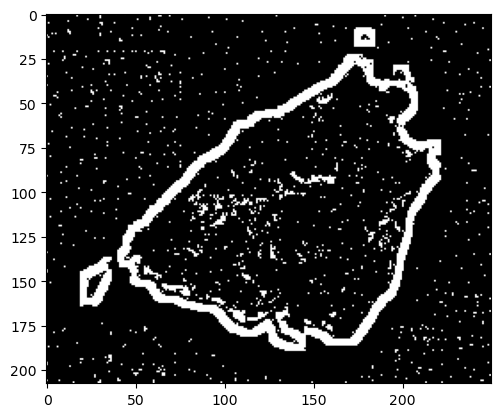

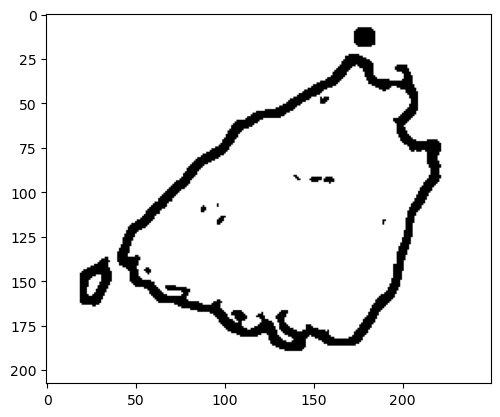

In [124]:
def medfilter(img):
    h,w,d=img_b.shape
    npimg=np.array(img)
    newimg = np.zeros((h+4,w+4,3), dtype=np.uint8)
    newimg[2:h+2,2:w+2]=npimg
    med5=np.full((5,5,3),1, dtype=np.single)
    for i in range(2,h+2):
        for j in range(2,w+2):
            x=newimg[i-2:i+3,j-2:j+3]
            x=np.multiply(x,med5)
            s=np.median(x)
            npimg[i-2][j-2]=s
    output=255-npimg
    output=Image.fromarray(output)
    return output
img = cv2.imread('input6.bmp')
kernel = np.ones((3,3), np.uint8)
img_d = cv2.dilate(img, kernel, iterations=4)
img_b=img-img_d
ret, img_t = cv2.threshold(img_b,180,255, cv2.THRESH_BINARY_INV)
plt.imshow((img_t))
plt.show()
plt.imshow(medfilter(img_t))
plt.show()

# Q4

Original image


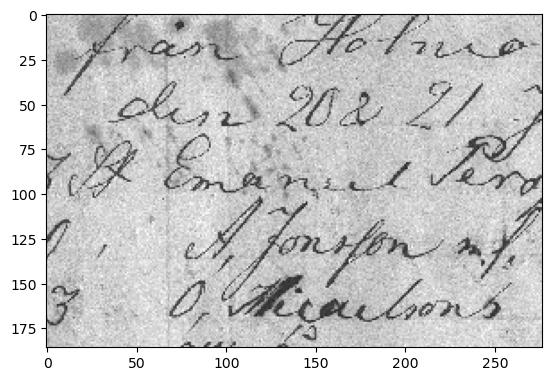

After thresholding


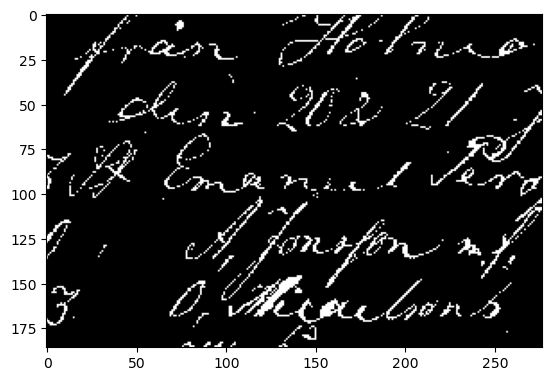

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image after adaptive thresholding


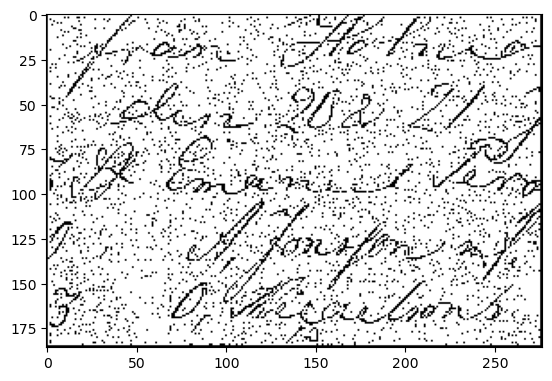

In [111]:
img_unp = cv2.imread('input7.bmp')  #importing image
m, n,q = img_unp.shape                  #taking dimensions
print("Original image")
plt.imshow(img_unp)
plt.show()

npimg=np.array(img_unp)
newimg = np.zeros((m+2,n+2,3), dtype=np.uint8)
newimg[1:m+1,1:n+1]=npimg
mask=np.full((3,3),1/9, dtype=np.single)
img=newimg
for i in range(m):              
    for j in range(n):
        if(img_unp[i,j,0]<100):
            img_unp[i,j] = 255,255,255
        else:
            img_unp[i,j] = 0,0,0

print("After thresholding")
plt.imshow(img_unp)
plt.show()

img_new = np.zeros([m, n,3])                    

for i in range(1, m-1):   
    for j in range(1, n-1):     #calculating average for each pixel's neighbours 
        temp = img[i-1, j-1,0]*mask[0, 0]+img[i-1, j,0]*mask[0, 1]+img[i-1, j + 1,0]*mask[0, 2]+img[i, j-1,0]*mask[1, 0]+ img[i, j,0]*mask[1, 1]+img[i, j + 1,0]*mask[1, 2]+img[i + 1, j-1,0]*mask[2, 0]+img[i + 1, j,0]*mask[2, 1]+img[i + 1, j + 1,0]*mask[2, 2]
        if(img[i,j,0]>(temp-21)):            #if pixel is greater than average
            img_new[i, j]= 255,255,255          #assign value of 255
        else:
            img_new[i,j] = 0,0,0            #otherwise assign 0

print("After adaptive thresholding")
plt.imshow(img_new)
plt.show()